# Unmyelinated C-fiber model - convergence study

## Objectives
- Implement unmyelinated fiber model working with intracellular and extracellular current stimulation, as well as acoustic stimulation.


- Simulate the model with different diameters upon intracellular current injection at the central node, for increasing spatial resolution (i.e. decreasing node length)
- Quantify the model convergence via 3 output metrics: stimulation threshold, conduction velocity and spike amplitude
- Evaluate the required spatial resolution (node length) to achieve a reliable convergence within an error margin (relative to maximal resolution).


- Simulate the model with different diameters upon intracellular current injection at the central node, for increasing fiber length
- Evaluate the required fiber length to achieve a reliable convergence


- Simulate the model with the parameters used in the Sundt paper, and compare the results with the Sundt ones.

## Rationale

An single-cable unmyelinated fiber model is constructed by simply setting internodal length to zero, and specifying fixing fiber length at instantiation. 
The number of nodes is derived from the required spatial resolution (i.e. the maximal node length), also specified at instantiation. 

Spatial resolution is expected to greatly affect simulations, since:
- low resolution could yield inaccurate simulation results (conduction velocity, spike amplitude), and eventually lead to action potential propagation failure 
- high resolution could induce a dramatic increase in computation time 

Therefore, we wish to find a trade-off in spatial resolution, with a node length small enough to produce accurate results, yet large enough to keep computation times reasonable. 

## Imports

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PySONIC.core import PulsedProtocol
from PySONIC.neurons import getPointNeuron
from PySONIC.utils import logger, si_format
from MorphoSONIC.core import UnmyelinatedFiber, IntracellularCurrent
from MorphoSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, plotConvergenceResults, plotCVvsDiameter
from MorphoSONIC.batches import FiberConvergenceBatch, ConductionVelocityBatch

logger.setLevel(logging.INFO)
#%matplotlib notebook

## Functions

In [2]:
def unmyelinatedFiberConvergence_maxNodeL(fiberD, fiberL, maxNodeL_range, pp, outdir='.'):
    fiber_func = lambda x: UnmyelinatedFiber(fiberD, fiberL=fiberL, maxNodeL=x)
    source_func = lambda fiber: IntracellularCurrent(fiber.central_ID)
    conv_batch = FiberConvergenceBatch('maxNodeL', fiber_func, source_func, maxNodeL_range[::-1], pp, root=outdir)
    conv_batch.run()
    return conv_batch.getLogData().iloc[::-1]

def unmyelinatedFiberConvergence_fiberL(fiberD, fiberL_range, pp, outdir='.'):
    fiber_func = lambda x: UnmyelinatedFiber(fiberD, fiberL=x)
    source_func = lambda fiber: IntracellularCurrent(fiber.central_ID)
    conv_batch = FiberConvergenceBatch('fiberL', fiber_func, source_func, fiberL_range, pp, root=outdir)
    conv_batch.run()
    return conv_batch.getLogData()

## Default parameters

We use identical parameters as in the Sundt 2015 paper (0.8 um diameter, 5 mm long peripheral axon with fast Sodium, delayed-rectifier Potassium and leakage currents).

The following parameters are fixed in the convergence studies. 

In [3]:
# Default fiber parameters
fiberL = 5e-3  # fiber length (m)

# Stimulation parameters
tstim = 10e-6     # s
toffset = 25e-3  # s
pp = PulsedProtocol(tstim, toffset)

# Spatial resolution

## Parameters for the convergence study about spatial resolution

We want to run convergence studies over the maximum node length for different diameters in the range [0.2, 1.5] um.
We select the intervals on which run the convergence, and adapt them in order to get a clear convergence in the intervals. 

We fix the relative threshold values to select the maximum node length values that ensure convergence, good accuracy but also a good trade off with the computational cost. 
The fiber current relative threshold is fixed at 5%, while the conduction velocity and spike amplitude ones are fixed at 1%. 

We select an higher relative threshold for Ithr because we accept some errors given by the spatial charge dispersion that can affect fiber segments with different lengths in different ways.

In [4]:
# Range for the convergence study
maxNodeL_range = np.logspace(np.log10(5e-6), -3, 100)  # maximum node length range: from 5 um to 1 mm

# Relative error thresholds for convergence study
rel_eps_thr_Ithr = 0.05  # for the fiber current threshold
rel_eps_thr = 0.01       # for the conduction velocity and spike amplitude

# Folder to store the convergence data
outdir = 'convergenceData'

## Run convergence for default diameter

 21/07/2020 20:01:33: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:33: resulting node length: 1.00 mm
 21/07/2020 20:01:33: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:33: parameter sweep successfully completed
 21/07/2020 20:01:33: max nodeL (m) = 2.22e-05
 21/07/2020 20:01:33: Convergence excitation current threshold = 6.68 nA
 21/07/2020 20:01:33: Convergence conduction velocity = 0.45 m/s
 21/07/2020 20:01:33: Convergence spike amplitude = 88.11 mV


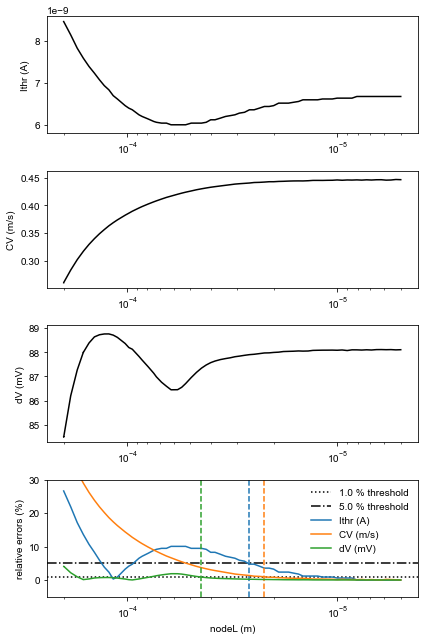

In [5]:
fiberD = 0.8e-6     # peripheral axon diameter, from Sundt 2015 (m)
df = unmyelinatedFiberConvergence_maxNodeL(fiberD, fiberL, maxNodeL_range, pp, outdir)

_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr_Ithr=rel_eps_thr_Ithr, rel_eps_thr=rel_eps_thr)

As we can see, as the node length is decreased, the 3 output metrics converge to specific asymptotic values:
- excitation threshold: 6.68 nA
- conduction velocity: 0.45 m/s
- spike amplitude: 88.1 mV

Setting a maximum relative error of 5%, we deduce that **a node length of around 22.2 um is required to achieve a reasonable accuracy**. Such a node length does not heavily compromise the computation time (model construction and simulation within a few seconds).

That number is in accordance (same order of magnitude) with the discretization strategy used in Sundt 2015 (100 segments for a 5 mm long peripheral axon, i.e. 50 um length per segment).

## Exploring other diameters

In order to make sure that our discretization threshold is robust, let us re-run the convergence study for other fiber diameters within the physiologically realistic range:

### 0.2 um diameter

 21/07/2020 20:01:38: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:38: resulting node length: 1.00 mm
 21/07/2020 20:01:38: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:38: parameter sweep successfully completed
 21/07/2020 20:01:38: max nodeL (m) = 1.24e-05
 21/07/2020 20:01:38: Convergence excitation current threshold = 0.83 nA
 21/07/2020 20:01:38: Convergence conduction velocity = 0.22 m/s
 21/07/2020 20:01:38: Convergence spike amplitude = 88.06 mV


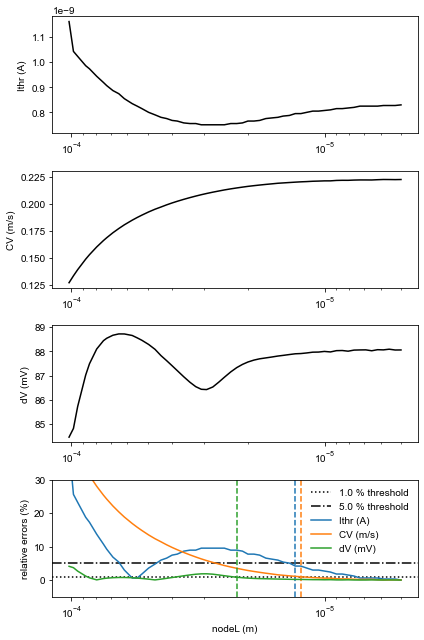

In [6]:
fiberD = 0.2e-6  # (m)
df = unmyelinatedFiberConvergence_maxNodeL(fiberD, fiberL, maxNodeL_range, pp, outdir)
_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr_Ithr=rel_eps_thr_Ithr, rel_eps_thr=rel_eps_thr)

As the node length is decreased, the 3 output metrics converge to the asymptotic values:
- excitation threshold: 0.83 nA
- conduction velocity: 0.22 m/s
- spike amplitude: 88.1 mV

Decreasing the diameter, the excitation threshold decrease of one order of magnitude and the conduction velocity halves. The spike amplitude remain the same, and we could expect that the spike amplitude depends only on the point neuron model and not on the diameter. 

The node length required to achieve a reasonable accuracy is **12.4 um**: it becomes lower decreasing the fiber diameter.

### 1.5 um diameter

 21/07/2020 20:01:41: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:41: resulting node length: 1.00 mm
 21/07/2020 20:01:41: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:42: parameter sweep successfully completed
 21/07/2020 20:01:42: max nodeL (m) = 2.22e-05
 21/07/2020 20:01:42: Convergence excitation current threshold = 17.23 nA
 21/07/2020 20:01:42: Convergence conduction velocity = 0.61 m/s
 21/07/2020 20:01:42: Convergence spike amplitude = 88.13 mV


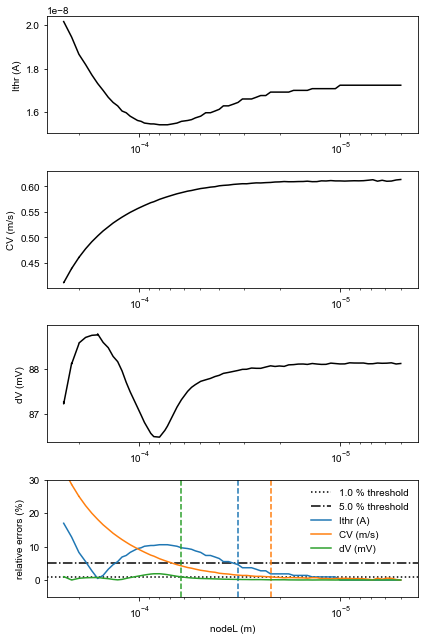

In [7]:
fiberD = 1.5e-6  # (m)
df = unmyelinatedFiberConvergence_maxNodeL(fiberD, fiberL, maxNodeL_range, pp, outdir)
_, inkey, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr_Ithr=rel_eps_thr_Ithr, rel_eps_thr=rel_eps_thr)

As the node length is decreased, the 3 output metrics converge to the asymptotic values:
- excitation threshold: 17.2 nA
- conduction velocity: 0.61 m/s
- spike amplitude: 88.1 mV

Increasing the diameter, the excitation threshold and the conduction velocity increase. The spike amplitude remain the same. 

The node length required to achieve a reasonable accuracy is **22.2 um**: it becomes higher increasing the fiber diameter.

### Max node length rule

There is a clear dependency between the maximum node length needed to ensure convergence and the fiber diameter.
We need a function that describes it.

To do an interpolation we need more values, so we are going to compute the maximum node length threshold for other diameters.

 21/07/2020 20:01:47: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:47: resulting node length: 1.00 mm
 21/07/2020 20:01:47: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:47: parameter sweep successfully completed
 21/07/2020 20:01:47: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:47: resulting node length: 1.00 mm
 21/07/2020 20:01:47: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:47: parameter sweep successfully completed
 21/07/2020 20:01:47: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:47: resulting node length: 1.00 mm
 21/07/2020 20:01:47: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:47: parameter sweep successfully completed
 21/07/2020 20:01:47: creating model with maxNodeL = 1.00 mm ...
 21/07/2020 20:01:47: resulting node length: 1.00 mm
 21/07/2020 20:01:47: running maxNodeL parameter sweep (5.00 um - 1.00 mm)
 21/07/2020 20:01:47: parameter sweep success

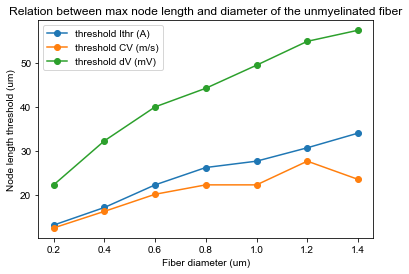

In [8]:
def maxNodeL_thrs(df, inkey, outkeys, rel_eps_thr_Ithr=rel_eps_thr_Ithr, rel_eps_thr=rel_eps_thr):
    ''' Function to get the node length convergence threshold from data table. '''
    eps = {}      # relative errors of each output metrics
    xin_thr = {}  # threshold input values according to each output metrics
    xin = df[inkey].values
    for i, k in enumerate(outkeys):
        xout = df[k].values
        xref = xout[-1]
        eps[k] = np.abs((xout - xref) / xref)
        j = eps[k].size - 1
        if i is 0:
            rel_thr = rel_eps_thr_Ithr
        else:
            rel_thr = rel_eps_thr
        while eps[k][j] <= rel_thr and j>0:
            j -= 1
        xin_thr[k] = xin[j + 1]
    return xin_thr

def plotThresholdVsDiameter(diameters, thresholds):
    fig, ax = plt.subplots()
    ax.set_xlabel('Fiber diameter (um)')
    ax.set_ylabel('Node length threshold (um)')
    ax.set_title('Relation between max node length and diameter of the unmyelinated fiber')
    for k, v in thresholds.items():
        ax.plot(diameters * 1e6, v * 1e6, marker='o', label=f'threshold {k}')
    ax.legend()
    return fig, ax

diameters = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]) * 1e-6  # m
thresholds = pd.DataFrame(columns=outkeys)
for fiberD in diameters:
    df = unmyelinatedFiberConvergence_maxNodeL(fiberD, fiberL, maxNodeL_range, pp, outdir)
    _, inkey, *outkeys = list(df.columns)
    out = pd.Series(maxNodeL_thrs(df, inkey, outkeys, rel_eps_thr_Ithr=rel_eps_thr_Ithr, rel_eps_thr=rel_eps_thr))
    thresholds = thresholds.append(out, ignore_index=True)

fig, _ = plotThresholdVsDiameter(diameters, thresholds)

Linear relation between nodelength_thrs and diameters: m = 16.4 and q = 9.1 um
Absolute maximum node length: 22.22 um


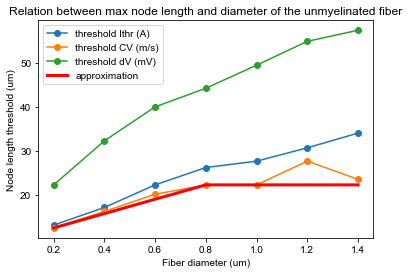

In [9]:
# Node length threshold approximation (linear in below 0.8 um, constant above 0.8 um)
dthr = 0.8e-6  # m
ithr = np.where(diameters == dthr)[0][0]
m_lin = (thresholds.iloc[ithr, :].min() - thresholds.iloc[0, :].min()) / (diameters[ithr] - diameters[0])
q_lin = thresholds.iloc[0, :].min() - m_lin * diameters[0]    #um
nodeL_fit = lambda x: m_lin * x + q_lin
nodeL_abs_thr = nodeL_fit(dthr)
print (f'Linear relation between nodelength_thrs and diameters: m = {(m_lin):.1f} and q = {(q_lin * 1e6):.1f} um')
print(f'Absolute maximum node length: {nodeL_abs_thr * 1e6:.2f} um')

linear_diameters, constant_diameters = diameters[:ithr], diameters[ithr:]
thr_approx = np.hstack((nodeL_fit(linear_diameters), nodeL_abs_thr * np.ones(len(constant_diameters))))
fig, ax = plotThresholdVsDiameter(diameters, thresholds)
ax.plot(diameters * 1e6, thr_approx * 1e6, label='approximation', color='r', linewidth=3)
ax.legend();

The more stringent criterion is the conduction velocity one.

Thanks to the results of the convergence studies for different diameters, we can extract a relation to approximate the relation between the node length required to achieve thr relative error chosen and the fiber diameter. 
In the diameter interval [0.2, 0.8] we use a linear relation, while in the following interval [0.8, 1.5] we use a constant one.
The approximation curve is under the real one, so our function is more stringent. 

**node length thr (um)  =  fiber diameter (um) * 16.4  +  9.1 um**

**max node length (um) = min (node length thr(fiber diameter), 22 um)**

The node length values used are of the same order of magnitude of the one used in the Sundt paper (50 um).
In the following studies we are going to compute the maximum node length for the unmyelinated fiber with the relation above.

# Exploring other fiber lengths

The default fiber length is 5 mm.

In order to make sure that our result is robust, let's re-run the convergence study over the fiber length to get che minimum fiber length that ensure accurate results. And compare this value to the default one.

## Parameters for the convergence study about fiber length

In [10]:
# Range for the convergence study
fiberL_range = np.logspace(-4, -2, 50)   # fiber length range: from 0.1 mm to 10 mm

# Relative error thresholds for convergence study
rel_eps_thr_Ithr = 0.05  # for the fiber current threshold
rel_eps_thr = 0.01       # for the conduction velocity and spike amplitude

### 0.2 um diameter

 21/07/2020 20:01:53: creating model with fiberL = 100.00 um ...
 21/07/2020 20:01:53: fiber length must be at least 3.0 mm
 21/07/2020 20:01:53: resulting node length: 11.11 um
 21/07/2020 20:01:53: running fiberL parameter sweep (100.00 um - 10.00 mm)
 21/07/2020 20:01:53: parameter sweep successfully completed
 21/07/2020 20:01:53: To reach convergence fiberL (m) = 1.05e-03
 21/07/2020 20:01:53: Convergence excitation current threshold = 0.80 nA
 21/07/2020 20:01:53: Convergence conduction velocity = 0.22 m/s
 21/07/2020 20:01:53: Convergence spike amplitude = 87.90 mV


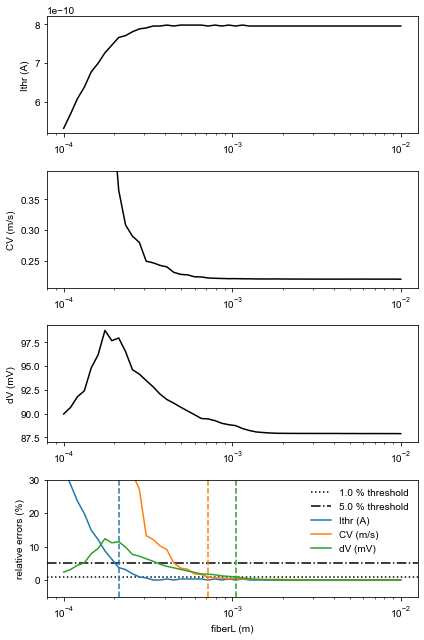

In [11]:
fiberD = 0.2e-6  # (m)
df = unmyelinatedFiberConvergence_fiberL(fiberD, fiberL_range, pp, outdir)
inkey, _, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr, axesdirection='a')

### 1.5 um diameter

 21/07/2020 20:01:55: creating model with fiberL = 100.00 um ...
 21/07/2020 20:01:55: fiber length must be at least 3.0 mm
 21/07/2020 20:01:55: resulting node length: 20.00 um
 21/07/2020 20:01:55: running fiberL parameter sweep (100.00 um - 10.00 mm)
 21/07/2020 20:01:55: parameter sweep successfully completed
 21/07/2020 20:01:55: To reach convergence fiberL (m) = 2.68e-03
 21/07/2020 20:01:55: Convergence excitation current threshold = 16.92 nA
 21/07/2020 20:01:55: Convergence conduction velocity = 0.61 m/s
 21/07/2020 20:01:55: Convergence spike amplitude = 88.00 mV


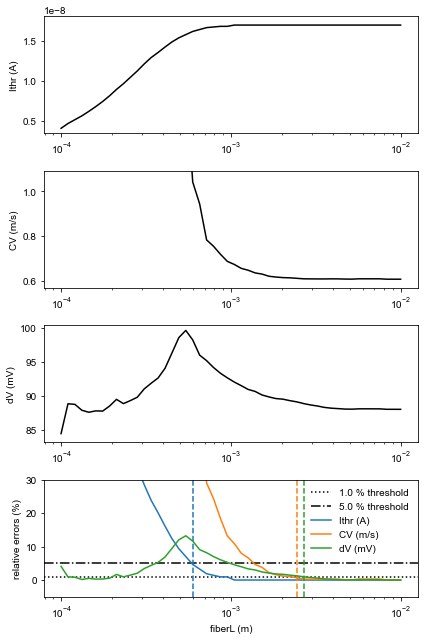

In [12]:
fiberD = 1.5e-6  # (m)
df = unmyelinatedFiberConvergence_fiberL(fiberD, fiberL_range, pp, outdir)

inkey, _, *outkeys = list(df.columns)
fig = plotConvergenceResults(df, inkey, outkeys, rel_eps_thr=rel_eps_thr, axesdirection='a')

The more stringent criterion here is the spike amplitude one. 

As we see form the comparison of the results for different diameters: higher is diameter, longer has to be the fiber to get the chosen accuracy value. 

The maximum diameter for an unmyelinated fiber is 1.5 um, so we can set the minimum fiber length required to ensure good results for all the unmelinated fiber at 3 mm. We leave 5 mm as default value since it is above the threshold and we are going to add a warning message if the fiber length is below this value. 

## Simulation with default parameters

In this section we run the simulation of the response of the typical Sundt fiber (parameters taken from the Sundt paper) with the node length and fiber length found with the convergence studies. 

The stimulation current applied has the amplitude 1.2 above the threshold value.

In [14]:
fiberD = 0.8e-6  # m
fiberL = 5e-3    # m
tstim = 1e-3     # s - duration of the stimulation in Sundt paper
toffset = 10e-3  # s
pp = PulsedProtocol(tstim, toffset)
fiber = UnmyelinatedFiber(fiberD, fiberL)
source = IntracellularCurrent(fiber.central_ID)
logger.info(f'Running titration for {si_format(pp.tstim)}s pulse')
Ithr = fiber.titrate(source, pp)  # A
print(f'Excitation threshold: {Ithr*1e9:.2f} nA')
data, meta = fiber.simulate(source.updatedX(1.2 * Ithr), pp)

 21/07/2020 20:02:29: Running titration for 1 ms pulse
 21/07/2020 20:02:29: UnmyelinatedFiber(fiberD = 800.0 nm, 229 nodes): simulation @ IntracellularCurrent(sec_id=node114, I=10.0pA, mode=anode), tstim = 1ms, toffset = 10ms
 21/07/2020 20:02:30: UnmyelinatedFiber(fiberD = 800.0 nm, 229 nodes): simulation @ IntracellularCurrent(sec_id=node114, I=20.0pA, mode=anode), tstim = 1ms, toffset = 10ms
 21/07/2020 20:02:31: UnmyelinatedFiber(fiberD = 800.0 nm, 229 nodes): simulation @ IntracellularCurrent(sec_id=node114, I=40.0pA, mode=anode), tstim = 1ms, toffset = 10ms
 21/07/2020 20:02:31: UnmyelinatedFiber(fiberD = 800.0 nm, 229 nodes): simulation @ IntracellularCurrent(sec_id=node114, I=80.0pA, mode=anode), tstim = 1ms, toffset = 10ms
 21/07/2020 20:02:32: UnmyelinatedFiber(fiberD = 800.0 nm, 229 nodes): simulation @ IntracellularCurrent(sec_id=node114, I=160.0pA, mode=anode), tstim = 1ms, toffset = 10ms
 21/07/2020 20:02:34: UnmyelinatedFiber(fiberD = 800.0 nm, 229 nodes): simulation @ 

cv = 0.45 m/s
dV = 84.93 V


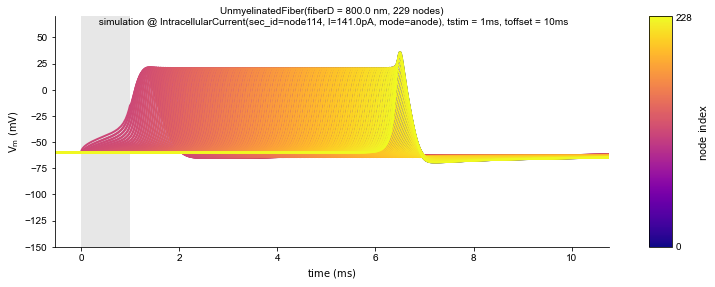

In [15]:
fig = SectionCompTimeSeries([(data, meta)], 'Vm', fiber.nodeIDs).render()
print(f'cv = {fiber.getConductionVelocity(data, out="median"):.2f} m/s')
print(f'dV = {fiber.getSpikeAmp(data, out="median"):.2f} V')

As we can see, the behavior of the unmyelinated C-fiber model is in good correspondence with the reference literature (Sundt 2015):
- conduction velocity (0.44 m/s) is slightly slower than reported in the paper (0.54 m/s for the peripheral axon) but agrees with ModelDB simulation results


- action potential waveform (ca. 1-2 ms duration, ca. 88 mV amplitude) seems in line with the paper results (ca. 1-2 ms duration, ca. 76 mV amplitude)


- the excitation threshold (0.12 nA) is in line with the just supra-threshold range of 0.2 nA used in the paper to stimulate the peripheral axon

 21/07/2020 20:02:55: creating model with fiberD = 200.00 nm ...
 21/07/2020 20:02:55: running fiberD parameter sweep (200.00 nm - 1.40 um)
 21/07/2020 20:02:55: parameter sweep successfully completed


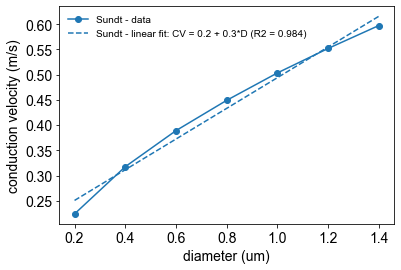

In [16]:
tstim = 1e-3     # s - duration of the stimulation in Sundt paper
toffset = 50e-3  # s - to allow for total AP travel even in slowest cases
pp = PulsedProtocol(tstim, toffset)
CV_vs_fiberD = ConductionVelocityBatch(
    lambda x: UnmyelinatedFiber(x),
    lambda x: IntracellularCurrent(x.central_ID),
    diameters, pp, root=outdir).run()
fig = plotCVvsDiameter(diameters, {'Sundt': CV_vs_fiberD})

## Conclusions  
- The unmyelinated neuron fiber model is implemented.
- A maximal node length can be computed in dependency of the fiber diameter with a linear behaviour with upper threshold (allowing for a 5% relative error in Ithr metric and 1% in conduction velocity and spike amplitude metrics).
- The fiber length shold be at least 3 mm, to ensure accuracy in the typical diameter range for unmyelinated fibers.
- The model is validated, since the results with default parameters are similar to the Sundt ones.

## References

- Sundt D, Gamper N, Jaffe DB., *Spike propagation through the dorsal root ganglia in an unmyelinated sensory neuron: a modeling study*, J Neurophysiol 114: 3140–3153, 2015.